<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Lesson23_TimeSeries/TimeSeries_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение для временных рядов

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.0 MB/s eta 0:00:00


In [ ]:

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 7, 5

### Предобработка временного ряда  <a name="preprocess">

Возьмем датасет, в котором будет присутвовать переменная, изменяющася во времени. Давайте сегодня попробуем поработать с набором данных по среднесуточной дневной температуре в городе Дели, собранном за несколько лет. Подробнее почитать про датасет можно на [Kaggle](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)

Датасет сразу разбит на две части - train и test, но будем использовать для обучения и валидации моделей только train, оставив test как отложенную выборку для проверки качества.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/DailyDelhiClimateTrain.csv')

print(f"Дни с {min(df.date)} по {max(df.date)}, всего {df.date.nunique()} дней.")
df.head()

Дни с 2013-01-01 по 2016-12-31, всего 1461 дней.


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

df = df[['date','meantemp']].set_index('date')

df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


<Axes: xlabel='date'>

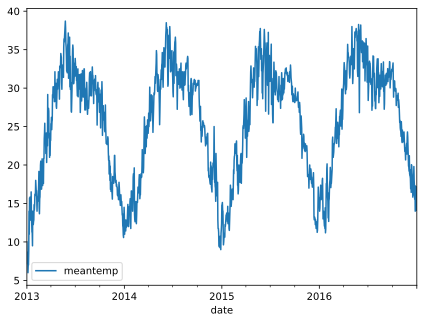

In [ ]:
df.plot()

### Генерация признаков <a name="features">

Основные подходы по генерации признаков:

* лаговые признаки (lags) - значения ряда в предыдущие моменты времени

* агрегации (среднее значение ряда по часу, дню, месяцу и так далее; медиана, дисперсия и так далее)


Напишем функцию, которая возвращает словарь, где ключами являются уникальные категории признака cat_feature, а значениями - средние по real_feature.

In [ ]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

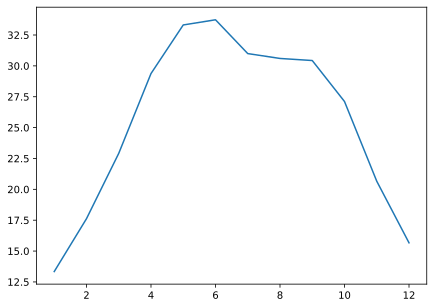

In [ ]:
df["month"] = df.index.month

d = code_mean(df, "month", "meantemp")

plt.plot(d.keys(), d.values())

Можно это удобно обернуть в функцию и заменить исходные признаки на их среднее как один из вариантов препроцессинга, а также - добавить значения целевой переменной с разной длинной временного лага.

В функции мы:

1) Разбиваем данные на тренировочную и тестовую части

2) Генерируем лаговые признаки

3) Генерируем агрегированные признаки

In [ ]:
def preprocess_data(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.meantemp.shift(i)

#    data["weekday"] = data.index.weekday
#    data["week"] = data.index.week
    data["month"] = data.index.month
    data["year"] = data.index.year

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
#    data["weekday_average"] = list(map(code_mean(data[:test_index], "weekday", "meantemp").get, data.weekday))
#    data["week_average"] = list(map(code_mean(data[:test_index], "week", "meantemp").get, data.week))
    data["month_average"] = list(map(code_mean(data[:test_index], "month", "meantemp").get, data.month))
    data["year_average"] = list(map(code_mean(data[:test_index], "year", "meantemp").get, data.year))

    # выкидываем закодированные средними признаки
    data.drop(['month', 'year'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["meantemp"], axis=1)
    y_train = data.loc[:test_index]["meantemp"]
    X_test = data.loc[test_index:].drop(["meantemp"], axis=1)
    y_test = data.loc[test_index:]["meantemp"]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(df, test_size=0.3, lag_start=3, lag_end=10)

X_train.head()

,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,month_average,year_average
0,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000,12.738377,24.791494
1,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,12.738377,24.791494
2,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,12.738377,24.791494
3,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,12.738377,24.791494
4,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,12.738377,24.791494


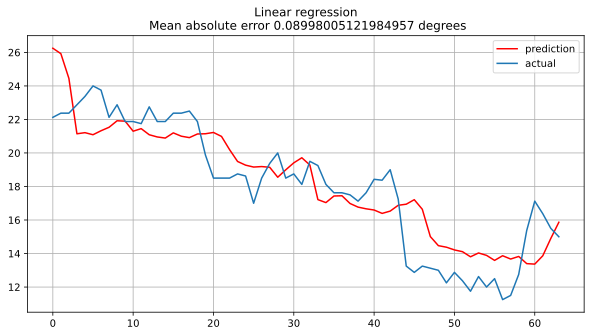

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_percentage_error(preds, y_test)} degrees");

In [ ]:
coef_table = pd.DataFrame({'features' : list(X_train.columns), 'weights' : lr.coef_})

coef_table.sort_values(by='weights')

,features,weights
6,lag_9,-0.019282
4,lag_7,0.001453
5,lag_8,0.014154
2,lag_5,0.029503
3,lag_6,0.036825
8,year_average,0.069640
1,lag_4,0.093203
0,lag_3,0.374786
7,month_average,0.460502


## DecisionTree

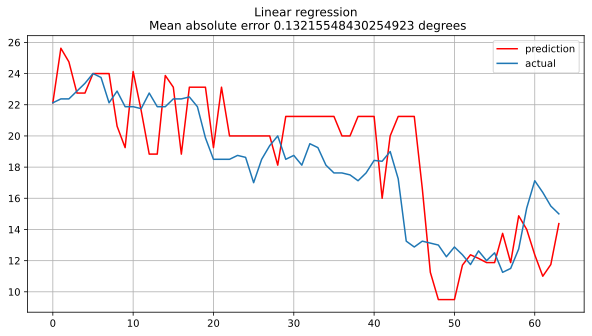

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
preds = dt.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_percentage_error(preds, y_test)} degrees");

## RandomForest

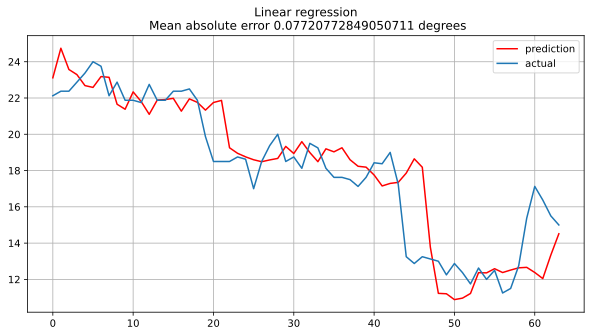

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_percentage_error(preds, y_test)} degrees");

## CatBoost

Learning rate set to 0.109355
0:	learn: 6.5586474	total: 57.5ms	remaining: 17.2s
1:	learn: 5.9911772	total: 59.8ms	remaining: 8.9s
2:	learn: 5.5017793	total: 65.5ms	remaining: 6.49s
3:	learn: 5.0449036	total: 75.8ms	remaining: 5.61s
4:	learn: 4.6496099	total: 94.1ms	remaining: 5.55s
5:	learn: 4.2899114	total: 98.7ms	remaining: 4.83s
6:	learn: 3.9868173	total: 115ms	remaining: 4.83s
7:	learn: 3.7250222	total: 125ms	remaining: 4.56s
8:	learn: 3.4872191	total: 132ms	remaining: 4.28s
9:	learn: 3.2812314	total: 135ms	remaining: 3.91s
10:	learn: 3.1198638	total: 138ms	remaining: 3.63s
11:	learn: 2.9570128	total: 141ms	remaining: 3.39s
12:	learn: 2.8148606	total: 148ms	remaining: 3.28s
13:	learn: 2.6955136	total: 151ms	remaining: 3.08s
14:	learn: 2.6070772	total: 154ms	remaining: 2.93s
15:	learn: 2.5332076	total: 165ms	remaining: 2.93s
16:	learn: 2.4636030	total: 168ms	remaining: 2.79s
17:	learn: 2.4022391	total: 174ms	remaining: 2.72s
18:	learn: 2.3428133	total: 180ms	remaining: 2.66s
19:	le

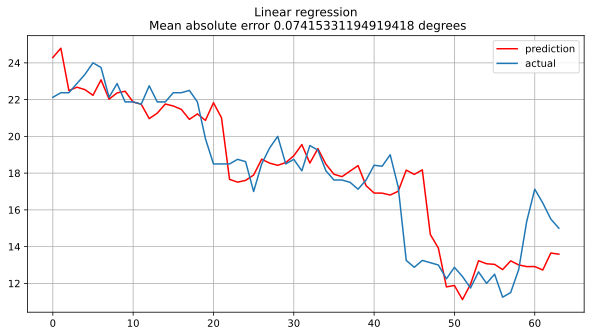

In [ ]:
cb = CatBoostRegressor(n_estimators=300)
cb.fit(X_train, y_train)
preds = cb.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_percentage_error(preds, y_test)} degrees");

In [ ]:
coef_table = pd.DataFrame({'features' : list(X_train.columns), 'weights' : cb.feature_importances_})

coef_table.sort_values(by='weights')

,features,weights
8,year_average,3.129962
4,lag_7,5.036109
3,lag_6,7.248722
6,lag_9,8.464532
2,lag_5,8.622694
5,lag_8,9.134931
7,month_average,14.857358
1,lag_4,17.147714
0,lag_3,26.357978
